In [14]:
# the purpose of this notebook is to make the figure showcasing how TPL and DTL endmember behavior 
# can be forced through changing Hstar
# these figures may also include cases using model runs with default parameters for comparison

In [15]:
# start by importing libraries
import numpy as np
import matplotlib.pyplot as plt

In [36]:
# now see if I can get a copied and pasted version of the two lithology model working
# and then tweak things, OAT, to see what the issue is with loooooong runtimes on this single lith model

# SET UP GRID ARRAYS
dx = 1000
x = np.arange(0, 100000, dx)

# set up runoff rate
r = np.zeros(len(x))
r[:] = 0.3

# set up references to topography
Hstar = 0.1
H = Hstar + np.zeros(len(x))
etab = -H
eta = etab + H

# abrasion coefficients from Attal and Lave 2006 in % per km
beta_ig = np.zeros(len(x))
beta_ig[:25] = 0.00004
beta_sed = np.zeros(len(x))
beta_sed[25:] = 0.00014
atr_factor = 0.00004

# erodibility values
k_ig = np.zeros(len(x))
k_ig[:25] = 0.0001
k_sed = np.zeros(len(x))
k_sed[25:] = 0.001

In [37]:
# write a function that has two bedrock lithologies in the domain, but only one contributing sediment to bedload
def two_lith_one_sed(x,
                     dx,
                     Hstar,
                     H,
                     etab,
                     eta,
                     beta_ig,
                     beta_sed,
                     atr_factor,
                     k_ig,
                     k_sed,
                     r,
                     c = 1,
                     baselevel_rate = 0.001,
                     num_steps = 100, 
                     porosity = 0.55):
    
    H[-1] = 0.0
    bedrock_ero = np.zeros(len(x))  # bedrock erosion rate
    sedimentation_rate = np.zeros(len(x))
    total_ero = np.zeros(len(x))
    total_ero[-1] = baselevel_rate
    q = r * x  # discharge = distance downstream (first node is left edge of 0th cell)
    qs = np.zeros(len(x))  # first node is left edge of 0th cell
    dt_global = 0.05 * 0.2 * dx * dx / (c*q[-1])  # "global" time-step size
    run_duration = dt_global * num_steps  # <== here's how long we want to run
    cum_time = 0.0  # <== keep track of elapsed time

    #for i in range(num_steps):
    while cum_time < run_duration:  # <== use a while loop because dt varies by iteration
        

        # first calculate rates
        
        #  calc slope
        S = -np.diff(eta)/dx
        
        #  calculate e factor
        efac = np.exp(- H / Hstar)
        
        #  calculate total bedload sed flux and set boundary condition
        qs[1:] = c * q[1:] * S * (1.0 - efac[:-1])
        qs[0] = 0
        
        #  calc bedrock erosion from stream power (plucking)
        ero_plucking_ig = efac[:-1] * (k_ig[1:] * q[1:] * S)
        ero_plucking_sed = efac[:-1] * (k_sed[1:] * q[1:] * S)
        
        #  calc bedrock erosion from abrasion
        ero_ab_ig = efac[:-1] * (beta_ig[:-1] * qs[1:])   # <== change indexing: qs[1] represents node 0
        ero_ab_sed = efac[:-1] * (beta_sed[:-1] * qs[1:])
        
        #  calc bedrock erosion rate from stream power and abrasion
        bedrock_ero[:-1] = ero_plucking_ig + ero_plucking_sed + ero_ab_ig + ero_ab_sed
        
        #  calc grain attrition rate
        atr = atr_factor * qs[1:]
        
        #  calc rate of change in alluvial thickness
        sedimentation_rate[:-1] = -((1 / porosity) * ((np.diff(qs)/dx) + atr - ero_plucking_ig))
        
        
        # Calculate maximum allowable time-step size
        
        #  track total erosion rate
        total_ero[:-1] = bedrock_ero[:-1] - sedimentation_rate[:-1]  # <== erosion is MINUS sed rate
        
        #  set adaptive timestep
        #  first check time to flat surface
        elev_diff = np.diff(eta)/dx
        ero_diff = np.diff(total_ero)/dx
        #valid_places = np.where(ero_diff < 0)
        valid_places = np.where(ero_diff < 0)[0]  # <== we just want the array, not the full tuple from where()
        if len(valid_places) > 0:  # <== in case there ARE no locations...
            times_to_flat = np.abs(elev_diff[valid_places]/ero_diff[valid_places])
        else:
            times_to_flat = np.array([dt_global])  # <== ...we just revert to the global dt
        min_time_to_flat = np.amin(times_to_flat)

        #  then check time to deplete all sediment
        #sed_depletion_locations = np.where(sedimentation_rate < 0)
        sed_depletion_locations = np.where(sedimentation_rate < 0)[0]  # <== we just want the array, not the full tuple from where()
        if len(sed_depletion_locations) > 0:  # <== in case there ARE no locations...
            times_to_no_sed = np.abs(H[sed_depletion_locations]/sedimentation_rate[sed_depletion_locations])
        else:
            times_to_no_sed = np.array([dt_global])  # <== ...we just revert to the global dt
        min_time_to_no_sed = np.amin(times_to_no_sed)

        #  check for smaller condition
        dt = min(min_time_to_flat, min_time_to_no_sed)

        #  if larger than global step size, limit to global
        dt = min(dt, dt_global)
        
        
        # Update quantities
        
        #  lower baselevel
        eta[-1] -= baselevel_rate * dt 
        
        #  set boundary conditions
        etab[-1] = eta[-1]
        
        #  calc change in bedrock elev
        etab[:-1] -= bedrock_ero[:-1] * dt
        
        #  update sediment thickness
        H[:-1] += sedimentation_rate[:-1] * dt
        H[H < 0] = 0

        #  update elev
        eta[:-1] = etab[:-1] + H[:-1]
        
        # Advance time
        cum_time += dt
        
        if any(total_ero[:] != baselevel_rate):
            continue
        else:
            break
            
    print(cum_time)
        
    return (S, qs, efac, eta, etab, ero_plucking_ig, ero_plucking_sed, ero_ab_ig, ero_ab_sed, bedrock_ero, atr, 
            sedimentation_rate, H, total_ero, cum_time)

In [38]:
# create the input experiment
default = [x, dx, Hstar, H, etab, eta, beta_ig, beta_sed, atr_factor, k_ig, k_sed, r]

# and run away with it!
(slope_default,
 sed_flux_default,
 alpha_default,
 topo_default,
 bedrock_elev_default,
 ig_plucking_rate_default,
 sed_plucking_rate_default,
 ig_abrasion_rate_default,
 sed_abrasion_rate_default,
 bedrock_erosion_rate_default,
 attrition_rate_default,
 sedimentation_rate_default,
 sediment_thickness_default,
 total_erosion_rate_default,
 cum_time_default) = two_lith_one_sed(*default)

34.006734006733986


In [39]:
# okay, that worked!
# check to see if we're at steady state
print(bedrock_erosion_rate_default)

[-0.00000000e+00 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00
 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00
 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00
 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00
 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00
 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00
 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00
 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00
 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00
 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00
 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00
 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00
 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00
 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00
 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00
 -0.00000000e+00 -0.00000

In [40]:
Hstar_TPL = 0.01
Hstar_DTL = 5

In [41]:
# SET UP GRID ARRAYS
dx_2 = 1000
x_2 = np.arange(0, 100000, dx_2)

# set up runoff rate
r_2 = np.zeros(len(x_2))
r_2[:] = 0.3

# set up references to topography
# Hstar_2 = Hstar_TPL
H_2 = Hstar + np.zeros(len(x_2))
etab_2 = -H_2
eta_2 = etab_2 + H_2

# abrasion coefficients from Attal and Lave 2006 in % per km
beta_ig_2 = np.zeros(len(x_2))
beta_ig_2[:25] = 0.00004
beta_sed_2 = np.zeros(len(x_2))
beta_sed_2[25:] = 0.00014
# atr_factor

# erodibility values
k_ig_2 = np.zeros(len(x_2))
k_ig_2[:25] = 0.0001
k_sed_2 = np.zeros(len(x_2))
k_sed_2[25:] = 0.001

In [42]:
# create the input experiment
TPL = [x_2, dx_2, Hstar_TPL, H_2, etab_2, eta_2, beta_ig_2, beta_sed_2, atr_factor, k_ig_2, k_sed_2, r_2]

# and run away with it!
(slope_TPL,
 sed_flux_TPL,
 alpha_TPL,
 topo_TPL,
 bedrock_elev_TPL,
 ig_plucking_rate_TPL,
 sed_plucking_rate_TPL,
 ig_abrasion_rate_TPL,
 sed_abrasion_rate_TPL,
 bedrock_erosion_rate_TPL,
 attrition_rate_TPL,
 sedimentation_rate_TPL,
 sediment_thickness_TPL,
 total_erosion_rate_TPL,
 cum_time_TPL) = two_lith_one_sed(*TPL)

34.006734006733986


In [43]:
# check for ss position
print(bedrock_erosion_rate_TPL)

[-0.00000000e+00 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00
 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00
 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00
 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00
 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00
 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00
 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00
 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00
 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00
 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00
 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00
 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00
 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00
 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00
 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00
 -0.00000000e+00 -0.00000

In [44]:
aplha_TPL-alpha_default

array([-0.36783404, -0.36783404, -0.36783404, -0.36783404, -0.36783404,
       -0.36783404, -0.36783404, -0.36783404, -0.36783404, -0.36783404,
       -0.36783404, -0.36783404, -0.36783404, -0.36783404, -0.36783404,
       -0.36783404, -0.36783404, -0.36783404, -0.36783404, -0.36783404,
       -0.36783404, -0.36783404, -0.36783404, -0.36783404, -0.36783404,
       -0.36783404, -0.36783404, -0.36783404, -0.36783404, -0.36783404,
       -0.36783404, -0.36783404, -0.36783404, -0.36783404, -0.36783404,
       -0.36783404, -0.36783404, -0.36783404, -0.36783404, -0.36783404,
       -0.36783404, -0.36783404, -0.36783404, -0.36783404, -0.36783404,
       -0.36783404, -0.36783404, -0.36783404, -0.36783404, -0.36783404,
       -0.36783404, -0.36783404, -0.36783404, -0.36783404, -0.36783404,
       -0.36783404, -0.36783404, -0.36783404, -0.36783404, -0.36783404,
       -0.36783404, -0.36783404, -0.36783404, -0.36783404, -0.36783404,
       -0.36783404, -0.36783404, -0.36783404, -0.36783404, -0.36

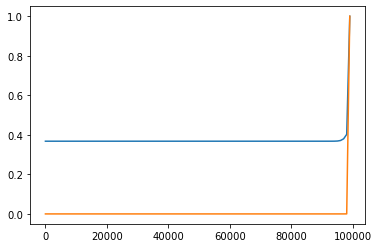

In [45]:
plt.plot(x, alpha_default)
plt.plot(x_2, alpha_TPL)

In [ ]:
# SET UP GRID ARRAYS
dx_3 = 1000
x_3 = np.arange(0, 100000, dx_3)

# set up runoff rate
r_3 = np.zeros(len(x_3))
r_3[:] = 0.3

# set up references to topography
# Hstar_3 = Hstar_DTL
H_3 = Hstar + np.zeros(len(x_3))
etab_3 = -H_3
eta_3 = etab_3 + H_3

# abrasion coefficients from Attal and Lave 2006 in % per km
beta_ig_3 = np.zeros(len(x_3))
beta_ig_3[:25] = 0.00004
beta_sed_3 = np.zeros(len(x_3))
beta_sed_3[25:] = 0.00014
# atr_factor

# erodibility values
k_ig_3 = np.zeros(len(x_3))
k_ig_3[:25] = 0.0001
k_sed_3 = np.zeros(len(x_3))
k_sed_3[25:] = 0.001

In [ ]:
# create the input experiment
DTL = [x_3, dx_3, Hstar_DTL, H_3, etab_3, eta_3, beta_ig_3, beta_sed_3, atr_factor, k_ig_3, k_sed_3, r_3]

# and run away with it!
(slope_DTL,
 sed_flux_DTL,
 alpha_DTL,
 topo_DTL,
 bedrock_elev_DTL,
 ig_plucking_rate_DTL,
 sed_plucking_rate_DTL,
 ig_abrasion_rate_DTL,
 sed_abrasion_rate_DTL,
 bedrock_erosion_rate_DTL,
 attrition_rate_DTL,
 sedimentation_rate_DTL,
 sediment_thickness_DTL,
 total_erosion_rate_DTL,
 cum_time_DTL) = two_lith_one_sed(*DTL)

In [ ]:
# check for ss condition
print(bedrock_erosion_rate_DTL)

In [ ]:
# now make the first function: pure stream power
# take out adaptive timstep stuff, only add it back in if it seems necessary

def stream_power(x,
                 dx,
                 eta,
                 k,
                 r,
                 c = 1, # should be 0.041, from W & S '19 (assuming constant geomorphically effective flow)
                 baselevel_rate = 0.001, # uplifting 1 mm/yr
                 num_steps = 100000, 
                 porosity = 0.55):
    
    bedrock_ero = np.zeros(len(x))  # bedrock erosion rate
    bedrock_ero[-1] = baselevel_rate
    q = r * x  # discharge = distance downstream (first node is left edge of 0th cell)
    dt = 0.2 * dx * dx / (c*q[-1])  # "global" time-step size # mult by 0.2
    
    for i in range(num_steps):

        # first calculate rates
        
        #  calc slope
        S = -np.diff(eta)/dx
        
        #  calc bedrock erosion rate from stream power (plucking)
        bedrock_ero[:-1] = k[1:] * q[1:] * S
        
        #  lower baselevel
        eta[-1] -= baselevel_rate * dt 
        
        #  calc change in bedrock elev
        eta[:-1] -= bedrock_ero[:-1] * dt
        
        if any(bedrock_ero[:] != baselevel_rate):
            continue
        else:
            break
            
        
    return (q, S, bedrock_ero, eta, i)

In [ ]:
# set up basic stuff

# grid
dx_sp = 1000
x_sp = np.arange(0, 100000, dx_sp)

# elevation
eta_sp = np.zeros(len(x_sp))

# set reasonable runoff rate in m/yr, see Rossi et al 2016 supplemental
r_sp = np.zeros(len(x_sp))
r_sp[:] = 0.3

# erodibility has both hard and soft rocks
k_sp = np.zeros(len(x_sp))
k_sp[:25] = 0.0001
k_sp[25:] = 0.001

In [ ]:
# now create an input experiment
SP = [x_sp, dx_sp, eta_sp, k_sp, r_sp]

# run experiment and catch outputs!
(discharge_SP,
 slope_SP,
 bedrock_erosion_rate_SP,
 topography_SP,
 i_SP) = stream_power(*SP)

In [ ]:
# check for ss condition
print(bedrock_erosion_rate_SP)

In [ ]:
kh = 0.3
area = kh * x**2

In [ ]:
m_def, b_def = np.polyfit(np.log(area[1:]), np.log(slope_default), 1)
m_def_up, b_def_up = np.polyfit(np.log(area[1:25]), np.log(slope_default[:24]), 1)
m_def_down, b_def_down = np.polyfit(np.log(area[25:]), np.log(slope_default[24:]), 1)

slope_fit_def = np.exp((m_def * np.log(area[1:])) + b_def)
slope_fit_up_def = np.exp((m_def_up * np.log(area[1:25])) + b_def_up)
slope_fit_down_def = np.exp((m_def_down * np.log(area[25:])) + b_def_down)

In [ ]:
m_tpl, b_tpl = np.polyfit(np.log(area[1:]), np.log(slope_TPL), 1)
m_tpl_up, b_tpl_up = np.polyfit(np.log(area[1:25]), np.log(slope_TPL[:24]), 1)
m_tpl_down, b_tpl_down = np.polyfit(np.log(area[25:]), np.log(slope_TPL[24:]), 1)

slope_fit_tpl = np.exp((m_tpl * np.log(area[1:])) + b_tpl)
slope_fit_up_tpl = np.exp((m_tpl_up * np.log(area[1:25])) + b_tpl_up)
slope_fit_down_tpl = np.exp((m_tpl_down * np.log(area[25:])) + b_tpl_down)

In [ ]:
m_dtl, b_dtl = np.polyfit(np.log(area[1:]), np.log(slope_DTL), 1)
m_dtl_up, b_dtl_up = np.polyfit(np.log(area[1:25]), np.log(slope_DTL[:24]), 1)
m_dtl_down, b_dtl_down = np.polyfit(np.log(area[25:]), np.log(slope_DTL[24:]), 1)

slope_fit_dtl = np.exp((m_dtl * np.log(area[1:])) + b_dtl)
slope_fit_up_dtl = np.exp((m_dtl_up * np.log(area[1:25])) + b_dtl_up)
slope_fit_down_dtl = np.exp((m_dtl_down * np.log(area[25:])) + b_dtl_down)

In [ ]:
m_sp, b_sp = np.polyfit(np.log(area[1:]), np.log(slope_SP), 1)
m_sp_up, b_sp_up = np.polyfit(np.log(area[1:25]), np.log(slope_SP[:24]), 1)
m_sp_down, b_sp_down = np.polyfit(np.log(area[25:]), np.log(slope_SP[24:]), 1)

slope_fit_sp = np.exp((m_sp * np.log(area[1:])) + b_sp)
slope_fit_up_sp = np.exp((m_sp_up * np.log(area[1:25])) + b_sp_up)
slope_fit_down_sp = np.exp((m_sp_down * np.log(area[25:])) + b_sp_down)

In [ ]:
print(topo_default[-1])
print(topo_TPL[-1])
print(topo_DTL[-1])
print(topography_SP[-1])

In [ ]:
adjustment = topography_SP[-1] - topo_default[-1]
fin_adj = adjustment - topo_TPL[-1]

In [ ]:
print(adjustment)

In [ ]:
pos_adj = (topo_default[-1] + adjustment)
print(topo_TPL[-1] + adjustment)
print(topo_DTL[-1] + adjustment)
print(topography_SP[-1])

In [ ]:
norm = topo_TPL[0] + adjustment - pos_adj
print(norm)

In [ ]:
# great, now see about making a figure that shows how TPL behavior is reached with this value

fig, axs = plt.subplots(3, figsize = (10, 12))
fig.suptitle('Steady state, transport-limited behavior due to low attrition rate', fontsize = 16, y = 0.95)
fig.subplots_adjust(hspace=0.5)

axs[0].plot(x/1000, (topo_default + adjustment - pos_adj)/norm, color = 'k', label = 'Default', linewidth = 3)
axs[0].plot(x_2/1000, (topo_TPL + adjustment - pos_adj)/norm, color = 'mediumseagreen', label = 'Transport limited', linewidth= 3)
axs[0].plot(x_3/1000, (topo_DTL + adjustment - pos_adj)/norm, color = 'teal', label = 'Detachment limited', linewidth = 3)
axs[0].plot(x_sp/1000, (topography_SP - pos_adj)/norm, color = 'gray', label = 'Stream power model', linewidth = 3, linestyle = '--')
axs[0].set_ylabel('Normalized elevation', fontsize = 12)
axs[0].set_xlabel('Distance (km)', fontsize = 12)
axs[0].legend(fontsize = 12)
axs[0].set_title('Topography', fontsize = 14)

axs[1].plot(x/1000, sed_flux_default, color = 'k', linewidth = 3)
axs[1].plot(x_2/1000, sed_flux_TPL, color = 'mediumseagreen', linewidth = 3)
axs[1].plot(x_3/1000, sed_flux_DTL, color = 'teal', linewidth =3)
axs[1].set_ylabel('Unit sediment flux ($m^2/yr$)', fontsize = 12)
axs[1].set_xlabel('Distance (km)', fontsize = 12)
axs[1].set_title('Sediment flux', fontsize = 14)

axs[2].loglog(area[1:25], slope_default[:24], color = 'k', linewidth = 3)
axs[2].loglog(area[25:], slope_default[24:], color = 'k', linewidth = 3)
axs[2].loglog(area[1:25], slope_fit_up_def, color = 'k', linestyle = ':', linewidth = 3)
axs[2].loglog(area[25:], slope_fit_down_def, color = 'k', linestyle = ':', linewidth = 3)

axs[2].loglog(area[1:25], slope_TPL[:24], color = 'mediumseagreen', linewidth = 3)
axs[2].loglog(area[25:], slope_TPL[24:], color = 'mediumseagreen', linewidth = 3)
axs[2].loglog(area[1:25], slope_fit_up_tpl, color = 'mediumseagreen', linestyle = ':', linewidth = 3)
axs[2].loglog(area[25:], slope_fit_down_tpl, color = 'mediumseagreen', linestyle = ':', linewidth = 3)

axs[2].loglog(area[1:25], slope_DTL[:24], color = 'teal', linewidth = 3)
axs[2].loglog(area[25:], slope_DTL[24:], color = 'teal', linewidth = 3)
axs[2].loglog(area[1:25], slope_fit_up_dtl, color = 'teal', linestyle = ':', linewidth = 3)
axs[2].loglog(area[25:], slope_fit_down_dtl, color = 'teal', linestyle = ':', linewidth = 3)

axs[2].loglog(area[1:25], slope_SP[:24], color = 'gray', linewidth = 3, linestyle = '--')
axs[2].loglog(area[25:], slope_SP[24:], color = 'gray', linewidth = 3, linestyle = '--')
axs[2].loglog(area[1:25], slope_fit_up_sp, color = 'gray', linestyle = ':', linewidth = 3)
axs[2].loglog(area[25:], slope_fit_down_sp, color = 'gray', linestyle = ':', linewidth = 3)

axs[2].set_ylabel('Slope', fontsize = 12)
axs[2].set_xlabel('Area ($m^2$)', fontsize = 12)
axs[2].set_title('Slope-area relationship', fontsize = 14)

#plt.savefig('/Users/vanessa/Desktop/summer 2022/fig6.png')
plt.show()

In [ ]:
plt.plot(x[1:], (ig_plucking_rate_default + sed_plucking_rate_default)/bedrock_erosion_rate_default[1:])
plt.plot(x[1:], (ig_abrasion_rate_default + sed_abrasion_rate_default)/bedrock_erosion_rate_default[1:])

plt.plot(x[1:], (ig_plucking_rate_TPL + sed_plucking_rate_TPL)/bedrock_erosion_rate_TPL[1:])
plt.plot(x[1:], (ig_abrasion_rate_TPL + sed_abrasion_rate_TPL)/bedrock_erosion_rate_TPL[1:])

plt.plot(x[1:], (ig_plucking_rate_DTL + sed_plucking_rate_DTL)/bedrock_erosion_rate_DTL[1:])
plt.plot(x[1:], (ig_abrasion_rate_DTL + sed_abrasion_rate_DTL)/bedrock_erosion_rate_DTL[1:])